<a href="https://colab.research.google.com/github/Abdelrahman-Alkhodary/Computer-Vision_with_tensorflow/blob/main/CNN_TF_Malaria_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Normalization, Dense, InputLayer, Conv2D, MaxPool2D, Flatten, Input, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError, BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError, BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import callbacks
from google.colab import drive
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

In [3]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteUKBXYG/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [4]:
print(dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [5]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path=PosixGPath('/tmp/tmp9kwo4eddtfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},

In [6]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  dataset_size = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*dataset_size))

  val_test_dataset  = dataset.skip(int(TRAIN_RATIO*dataset_size))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*dataset_size))
  test_dataset = val_test_dataset.skip(int(VAL_RATIO*dataset_size))
  return train_dataset, val_dataset, test_dataset

In [7]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [8]:
len(train_dataset), len(val_dataset), len(test_dataset)

(22046, 2755, 2757)

# **Data Visualization**

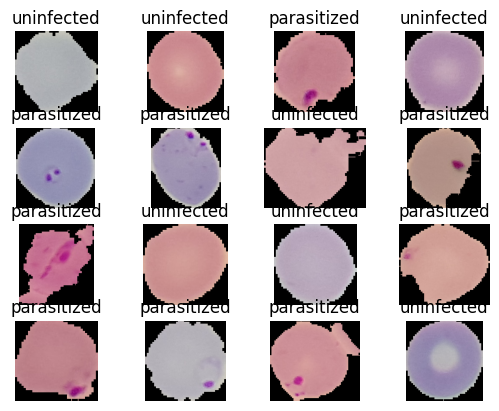

In [9]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [10]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  print(image.shape)

(151, 115, 3)
(121, 115, 3)
(157, 136, 3)
(151, 148, 3)
(133, 112, 3)
(109, 118, 3)
(115, 115, 3)
(103, 91, 3)
(118, 142, 3)
(145, 142, 3)
(187, 250, 3)
(136, 154, 3)
(166, 148, 3)
(124, 148, 3)
(136, 115, 3)
(121, 145, 3)


In [11]:
# we will define a function to resize the image of the dataset as images have different sizes
# new image size will be square of 224
IM_SIZE = 224
def resizing_rescaling(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255, label

In [12]:
train_dataset = train_dataset.map(resizing_rescaling)

In [13]:
val_dataset = val_dataset.map(resizing_rescaling)

test_dataset = test_dataset.map(resizing_rescaling)

In [14]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  print(image.shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


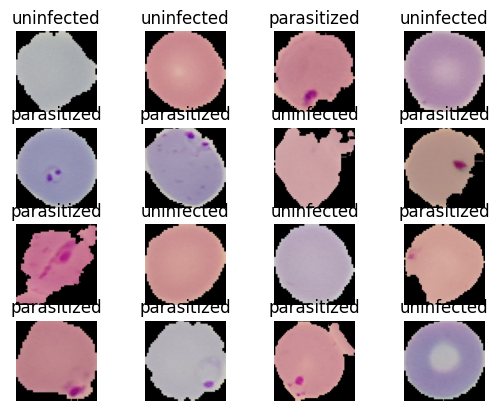

In [15]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [16]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [17]:
from keras.src.layers.serialization import activation
from keras.src.engine.training import input_ops
model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters=6, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Conv2D(filters=16, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Flatten(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [18]:
model.compile(
    optimizer=Adam(learning_rate=0.1),
    loss=BinaryCrossentropy(),
    metrics='accuracy'
)

In [19]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
689/689 [==============================] - 123s 151ms/step - loss: 0.6129 - accuracy: 0.6645 - val_loss: 8.8520 - val_accuracy: 0.5067
Epoch 2/20
689/689 [==============================] - 54s 78ms/step - loss: 0.4635 - accuracy: 0.7751 - val_loss: 0.7402 - val_accuracy: 0.6171
Epoch 3/20
689/689 [==============================] - 49s 71ms/step - loss: 0.5925 - accuracy: 0.6937 - val_loss: 0.5919 - val_accuracy: 0.6860
Epoch 4/20
689/689 [==============================] - 60s 87ms/step - loss: 0.5596 - accuracy: 0.7221 - val_loss: 2.0928 - val_accuracy: 0.5775
Epoch 5/20
689/689 [==============================] - 47s 68ms/step - loss: 0.5090 - accuracy: 0.7576 - val_loss: 6.7724 - val_accuracy: 0.5183
Epoch 6/20
689/689 [==============================] - 55s 79ms/step - loss: 0.3790 - accuracy: 0.8408 - val_loss: 0.6216 - val_accuracy: 0.7601
Epoch 7/20
689/689 [==============================] - 53s 78ms/step - loss: 0.2517 - accuracy: 0.9102 - val_loss: 0.6897 - val_accurac

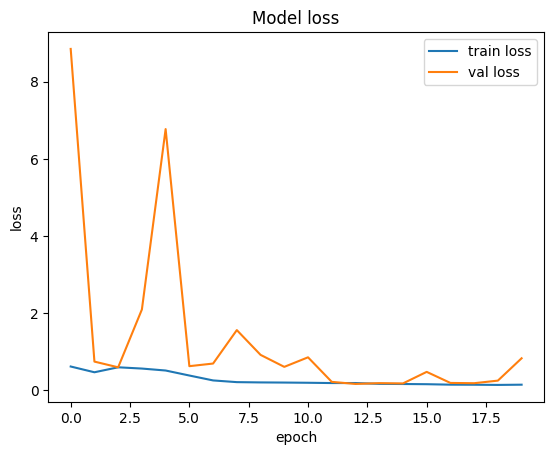

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'])
plt.show()

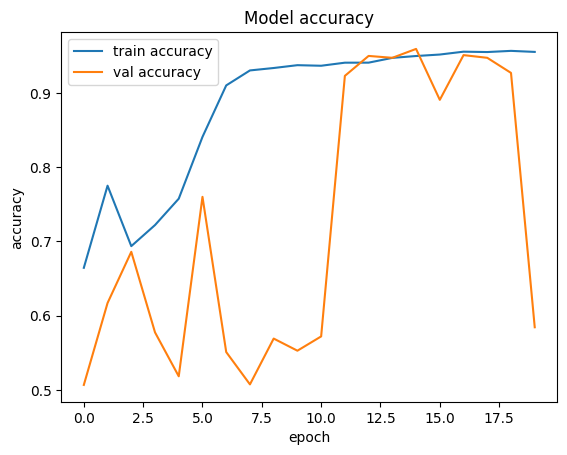

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'])
plt.show()

In [22]:
test_dataset = test_dataset.batch(1)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [23]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 26s 5ms/step - loss: 0.8631 - accuracy: 0.5803


[0.8630874156951904, 0.5803409218788147]

In [24]:
model.predict(test_dataset.take(1))

1/1 [==============================] - 12s 12s/step


array([[0.19181518]], dtype=float32)

In [25]:
def label_define(x):
  if x<0.5:
    return str('P')
  else:
    return str('U')

In [26]:
label_define(model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 12s 12s/step


'P'

In [27]:
model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 12s 12s/step


0.20759064

1/1 [==============================] - 0s 21ms/step


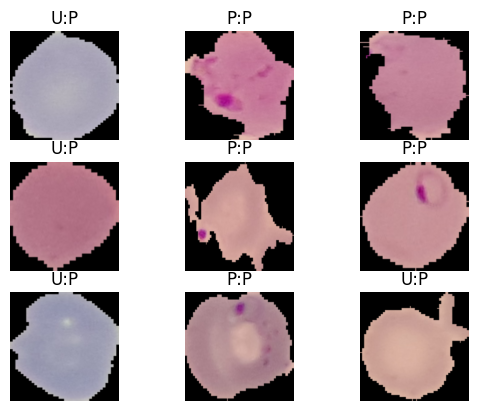

In [28]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3, i+1)
  plt.imshow(image[0])
  plt.title(str(label_define(label.numpy()[0])) + ':' + str(label_define(model.predict(image)[0][0])))
  plt.axis('off')
  # plt.show()

In [29]:
# save the model configuration and the model's weights
model.save('LenetSavedModel')

In [30]:
lenet_loaded_model = tf.keras.models.load_model('LenetSavedModel')
lenet_loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [31]:
lenet_loaded_model.evaluate(test_dataset)

2757/2757 [==============================] - 26s 5ms/step - loss: 0.8635 - accuracy: 0.5800


[0.8634573221206665, 0.5799782276153564]

In [32]:
model.save('Lenet.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
lenet_loaded_model = tf.keras.models.load_model('Lenet.hdf5')
lenet_loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [34]:
# save only the model's weights
model.save_weights('weights/lenet_weights')

Saving to Google Drive

In [35]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [36]:
# copy the model to the drive
!cp -r /content/LenetSavedModel/ /content/drive/MyDrive/lenet/

# Functional API

In [37]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3))

x = Conv2D(filters=6, kernel_size=3, strides=(1, 1), padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)
x = Conv2D(filters=16, kernel_size=3, strides=(1, 1), padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)

feature_extractor_model = Model(func_input, output, name='Feature_Extractor')
feature_extractor_model.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)

In [38]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3))

x = feature_extractor_model(func_input)

x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation='sigmoid')(x)

lenet_model = Model(func_input, func_output, name='Lenet_Modle')

lenet_model.summary()

Model: "Lenet_Modle"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 Feature_Extractor (Functio  (None, 54, 54, 16)        1136      
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_6 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 10)                

# Model Subclassing

In [3]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation) -> None:
    super(FeatureExtractor, self).__init__()
    self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size=2, strides=2)

    self.conv_2 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size=2, strides=2)

  def call(self, x):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)
    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_sub_classed = FeatureExtractor(6, 3, (1,1), 'valid', 'relu')

NameError: ignored

In [40]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3))

x = feature_sub_classed(func_input)

x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation='sigmoid')(x)

lenet_model = Model(func_input, func_output, name='Lenet_Modle')

lenet_model.summary()

Model: "Lenet_Modle"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Feature  (None, 54, 54, 6)         546       
 Extractor)                                                      
                                                                 
 flatten_2 (Flatten)         (None, 17496)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               1749700   
                                                                 
 batch_normalization_10 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 10)                

In [41]:
class LenetModel(Model):
  def __init__(self) -> None:
    super(LenetModel, self).__init__()
    self.feature_sub_classed = FeatureExtractor(6, 3, (1,1), 'valid', 'relu')

    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation='relu')
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation='relu')
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation='sigmoid')

  def call(self, x):
    print(x.shape)
    x = self.feature_sub_classed(x)
    print(x.shape)
    x = self.flatten(x)
    print(x.shape)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x


model_sub_classed = LenetModel()
model_sub_classed(tf.zeros([1,244,244,3]))
model_sub_classed.summary()

(1, 244, 244, 3)
(1, 59, 59, 6)
(1, 20886)
Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featu  multiple                  546       
 reExtractor)                                                    
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dense_9 (Dense)             multiple                  2088700   
                                                                 
 batch_normalization_14 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            multiple                  1010      
                                                                 
 batch_norma

In [42]:
metrics = [TruePositives(name='tp'), BinaryAccuracy(name='accuracy'), FalsePositives(name='fp'), FalseNegatives(name='fn'), TrueNegatives(name='tn'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [43]:
lenet_model.compile(optimizer=Adam(learning_rate=0.01),
                          loss=BinaryCrossentropy(),
                          metrics=metrics)

In [44]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

Epoch 1/5
689/689 [==============================] - 58s 77ms/step - loss: 0.2843 - tp: 9914.0000 - accuracy: 0.8896 - fp: 1326.0000 - fn: 1108.0000 - tn: 9698.0000 - precision: 0.8820 - recall: 0.8995 - auc: 0.9478 - val_loss: 2.3309 - val_tp: 1358.0000 - val_accuracy: 0.7688 - val_fp: 602.0000 - val_fn: 35.0000 - val_tn: 760.0000 - val_precision: 0.6929 - val_recall: 0.9749 - val_auc: 0.8290
Epoch 2/5
689/689 [==============================] - 78s 113ms/step - loss: 0.2031 - tp: 10449.0000 - accuracy: 0.9342 - fp: 874.0000 - fn: 577.0000 - tn: 10146.0000 - precision: 0.9228 - recall: 0.9477 - auc: 0.9668 - val_loss: 1.5037 - val_tp: 1386.0000 - val_accuracy: 0.7481 - val_fp: 685.0000 - val_fn: 9.0000 - val_tn: 675.0000 - val_precision: 0.6692 - val_recall: 0.9935 - val_auc: 0.8353
Epoch 3/5
689/689 [==============================] - 53s 77ms/step - loss: 0.2130 - tp: 10412.0000 - accuracy: 0.9295 - fp: 944.0000 - fn: 611.0000 - tn: 10079.0000 - precision: 0.9169 - recall: 0.9446 - au

In [2]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

NameError: ignored

# Visulaizing Confusion Matrix

In [46]:
labels = []
img_in = []

for x, y in test_dataset.as_numpy_iterator():
  labels.append(y)
  img_in.append(x)

In [49]:
labels = np.array([i[0] for i in labels])
print(labels)

[0 0 1 ... 0 1 1]


In [1]:
predicted = lenet_model.predict(np.array(img_in[:,0,...]))

NameError: ignored

In [ ]:
print(predicted)

In [ ]:
predicted_zero_one = np.where(1, predicted>0.5, 0)

In [ ]:
predicted = np.array([i[0] for i in predicted])

In [ ]:
print(predicted)

In [ ]:
confusion_matrix(labels, predicted_zero_one)

In [ ]:
threshold = 0.5
cm = confusion_matrix(labels, predicted_zero_one)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
fp, tp, thresholds = roc_curve(labels, predicted)


In [ ]:
plt.plot(fp, tp)
plt.xlabel('False Pos')
plt.ylabel("True pos")
plt.grid()

skip = 30
for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i])
plt.show()